In [3]:
# import the wrapper
from p21cmfastwrapper import *

TypeError: module() takes at most 2 arguments (3 given)

In [7]:
# The wrapper uses a parameter file to initialize the simulation for better overview
# One can initialize the class by
sim = Simulation(save_ondisk=False, write_cache=False, save_inclass=True, debug=True)
# important arguments for initializing the Simulation class are:
'''save_inclass (bool): If set true, results are saved as a list in the class, very useful for testing and quick analysis. If False, results are saved as a file
save_ondisk (bool): If set True, save results on disk
write_cache (bool): If true, use the included 21cmfast cache, useful when doing repeated simulations with same seed and init conditions.
data_path (str): path for saving the results of save_ondisk is True
file_name (str): filename for the runs, final name will be: filename + run_id + .h5
override (bool): If True, old runs will be overridden
debug (bool): Print many things along the way if something is screwed again.'''

use astro_params default config: True
use cosmo_params default config: True
use user_params default config: False
use flag_options default config: False
use global_params default config: True
./data/ run_* 1 ['run_0']
Using 21cmFAST version 0.1.dev1836+gf7c01bf


'save_inclass (bool): If set true, results are saved as a list in the class, very useful for testing and quick analysis. If False, results are saved as a file\nsave_ondisk (bool): If set True, save results on disk\nwrite_cache (bool): If true, use the included 21cmfast cache, useful when doing repeated simulations with same seed and init conditions.\ndata_path (str): path for saving the results of save_ondisk is True\nfile_name (str): filename for the runs, final name will be: filename + run_id + .h5\noverride (bool): If True, old runs will be overridden\ndebug (bool): Print many things along the way if something is screwed again.'

In [3]:
# To just run a single box using the parameters one can just 
sim.run_box()

In [8]:
# To simulate a lightcone, one can do
sim.run_cone()
# Now we clear the cached simulations for the next step
#sim.clear()

In [ ]:
# All parameters can be changed on the fly without re-initializing the class, e.g.
params = {"redshift": 8, "max_redshift": 12, "random_seed": 1, "astro_params": {"HII_EFF_FACTOR": 29}} 
# Note: It is important to preserve the dict structure defined in parameter.yaml for in-situ changes in parameters
# This dict needs to be passed as an argument to the wrapper
sim.run_lightcone(kargs=params)

In [ ]:
# One can also do multiple runs with different parameters, e.g. we want two realizations of two HII_EFF_FACTORs
params = {"random_seed": [1,2], "astro_params": {"HII_EFF_FACTOR": [29,31]}}
sim.run_fixed_multi_lightcone(rargs=params)
# The result will be four simulations stored in the class

In [ ]:
# One can sample from a distribution (callable function) given by samplef and a dict of ranges
# This is useful to create a database
# For cluster deployment, change the threads argument to the number of available cpu cores
samplef = (lambda a,b: np.random.uniform(a,b))
args = {"astro_params": 
            {"NU_X_THRESH": [400,700], 
            "HII_EFF_FACTOR": [20,40],
            "L_X": [30,50],
            "ION_Tvir_MIN": [4,5]},
        "cosmo_params":
            {"OMm": [0.1,0.3]},
        "global_params": 
            {"M_WDM": [1,3]}}
sim.run_samplef(nruns=12, args=args, samplef=samplef, threads = 6)

In [ ]:
# Now we visualize the result
# Visualize the power spectrum computed in 6 bins
sim.plot_ps(bins=6,compare=True)
# Plot the global quantities of the simulations
sim.plot_global_properties(observational_axis=True)
# Plot various fields of the simulation
sim.plot_imshow(fields=["brightness_temp","xH_box", "density"])


In [ ]:
# If a function is unclear, one can always look at the docstring for help
sim.plot_ps?

In [ ]:
np.array([1,23,np.NaN]).max()

In [ ]:
import numpy as np

In [ ]:
test = True
while test:
    print("hi :3")
    test = False

In [12]:
import py21cmfast as p21c
user_params = p21c.UserParams(
    HII_DIM=70, BOX_LEN=200, N_THREADS = 6
)
astro_params = p21c.AstroParams(
    INHOMO_RECO = True, USE_TS_FLUCT = True
)
lightcone = p21c.run_lightcone(
    global_quantities=["brightness_temp"],
    direc='_cache',
    write=False,
    user_params=user_params,
    astro_params=astro_params,
    redshift=5.5,
    max_redshift=20
)

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_utils.py:412: UserWarning: The following parameters to AstroParams are not supported: ['USE_TS_FLUCT']
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [2]:
from powerbox import get_power
import numpy as np
from matplotlib import pyplot as plt
import py21cmfast as p21c

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [24]:
lc = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
# choose the right boundaries such that it maches the redshift interval
bottom, top = 470, 555
print(lc.lightcone_redshifts[bottom:top])
print(lc.cell_size)

[7.74007234 7.7460052  7.75194411 7.75788905 7.76384004 7.76979703
 7.77576011 7.78172925 7.78770454 7.79368582 7.7996732  7.80566676
 7.81166634 7.81767212 7.823684   7.82970203 7.83572616 7.84175645
 7.84779291 7.85383555 7.8598843  7.86593933 7.87200049 7.87806789
 7.88414147 7.8902213  7.89630733 7.90239964 7.90849816 7.91460293
 7.92071395 7.9268313  7.93295486 7.93908478 7.94522103 7.95136342
 7.95751223 7.9636674  7.9698288  7.97599667 7.98217084 7.9883513
 7.99453825 8.00073143 8.00693104 8.01313712 8.01934954 8.02556835
 8.03179359 8.03802529 8.04426345 8.05050797 8.05675902 8.06301655
 8.06928047 8.07555095 8.08182784 8.0881113  8.09440128 8.10069772
 8.10700075 8.11331023 8.11962634 8.12594895 8.13227818 8.13861387
 8.14495622 8.15130519 8.15766071 8.16402284 8.17039164 8.17676703
 8.18314908 8.18953774 8.1959331  8.20233507 8.20874373 8.21515908
 8.22158118 8.22800988 8.23444538 8.24088751 8.24733642 8.25379214
 8.26025446]
1.8181818181818181


In [28]:
def ps2d(data, size, **kwargs):
    #size = data.shape
    ps_perp,k_perp, _ = get_power(data, boxlength=size, res_ndim=2,
                                  ignore_zero_mode=True, bin_ave=True, **kwargs) 
    ps_par, k_par, _ = get_power(data.T, boxlength=size, res_ndim=1,  
                                 ignore_zero_mode=True, bin_ave=True, **kwargs)
    ps_perp = np.mean(ps_perp,axis=1)
    ps_par = np.mean(ps_par, axis=(1,2))
    v = np.prod(size)
    ps = np.outer(ps_par*k_par, ps_perp*k_perp**2)
    return k_perp, k_par, ps

In [29]:
k_perp, k_par, ps = ps2d(lc.brightness_temp[:,:,bottom:top],
                         lc.cell_size*np.array([*lc.brightness_temp.shape[:2], top-bottom]))

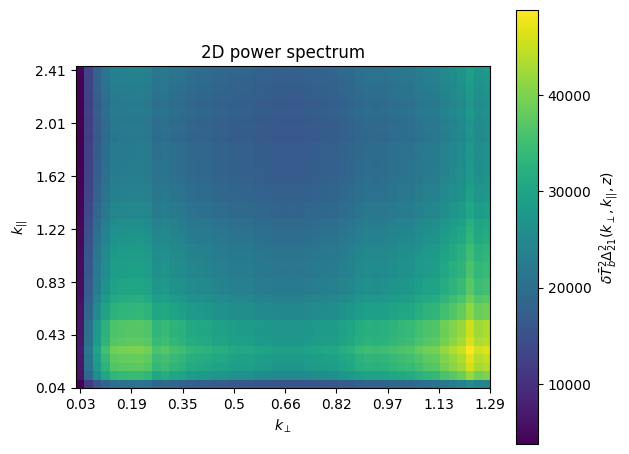

In [30]:
fig, ax = plt.subplots()
ax_img = ax.imshow(ps[::-1,:], )
dim_y, dim_x = ps.shape
num_y, num_x = (dim_y // 5, dim_x // 5)
ax.set_yticks(np.linspace(0,dim_y-0.5,num_y), np.round(np.linspace(k_perp.min(), k_perp.max(), num_y)[::-1], 2))
ax.set_xticks(np.linspace(0, dim_x-0.5, num_x),  np.round(np.linspace(k_par.min(), k_par.max(), num_x),2))
ax.set_xlabel(r"$k_\perp$")
ax.set_ylabel(r"$k_{||}$")
ax.set_title("2D power spectrum")
plt.colorbar(ax_img, ax=ax, label=r"$\delta \bar{T}_b^2 \Delta^2_{21}(k_\perp, k_{||}, z)$")

fig.tight_layout()
fig.savefig("./ps.jpg", dpi=300)

In [3]:
quantity = 111
threads = 13

def generate_ids(quantity, threads):
    counter = quantity
    while counter > 0:
        counter -= threads
        if counter > 0:
            yield np.linspace(quantity - (counter + threads),  quantity-counter-1, threads, dtype=int)
        else:
            yield np.linspace(quantity - (counter + threads),  quantity - 1, threads + counter, dtype=int)
        

In [5]:
for i in generate_ids(quantity, threads):
    print(i)

NameError: name 'generate_ids' is not defined

In [1]:
from Leaf import *

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [1]:
import py21cmfast as p21c

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [5]:
up = p21c.inputs.UserParams()
print(up)
up.update(**{})
print(up)

UserParams:
    BOX_LEN                 : 300.0
    DIM                     : 600
    FAST_FCOLL_TABLES       : False
    HII_DIM                 : 200
    HMF                     : 1
    KEEP_3D_VELOCITIES      : False
    MINIMIZE_MEMORY         : False
    NON_CUBIC_FACTOR        : 1.0
    NO_RNG                  : False
    N_THREADS               : 1
    PERTURB_ON_HIGH_RES     : False
    POWER_SPECTRUM          : 0
    USE_2LPT                : True
    USE_FFTW_WISDOM         : False
    USE_INTERPOLATION_TABLES: True
    USE_RELATIVE_VELOCITIES : False
    
UserParams:
    BOX_LEN                 : 300.0
    DIM                     : 600
    FAST_FCOLL_TABLES       : False
    HII_DIM                 : 200
    HMF                     : 1
    KEEP_3D_VELOCITIES      : False
    MINIMIZE_MEMORY         : False
    NON_CUBIC_FACTOR        : 1.0
    NO_RNG                  : False
    N_THREADS               : 1
    PERTURB_ON_HIGH_RES     : False
    POWER_SPECTRUM          : 0
 

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [90]:
un_lcsampling(self, samplef: Callable, redshift: float, save: bool = True, random_seed: int = None, 
                sanity_check: bool = True, make_statistics: bool = True, filter: bool = True,
                override: bool = False, threads: int = 1, mpi: bool = False, quantity: int = 1,
                astro_params_range: dict = None, cosmo_params_range: dict = None, user_params_range: dict = None,
                flag_options_range = None, global_params_range: dict = None)



Define global parameters...


In [2]:
from Leaf import *
user_parameter = {
    "HII_DIM": 140,
    "BOX_LEN": 200,
}
flag_options = {
    "INHOMO_RECO": False,
    "USE_TS_FLUCT": False
}

sim = Leaf(user_params=user_parameter, flag_options=flag_options, debug=True)

astro_params_range = {
    "L_X": [39.42, 39.84],
    "HII_EFF_FACTOR": [29,29.5]

}





#if __name__ == '__main__':
#    sim.run_lcsampling(samplef=sim.uniform, redshift=5.5, save=True, threads=2, quantity=4,
#                    astro_params_range=astro_params_range)

Set initial parameters...


In [5]:
blub = sim.run_lightcone(redshift=5.5, filter_peculiar=False, save=False, random_seed=42)
blub_right = sim.run_lightcone(redshift=5.5, filter_peculiar=False, save=False, random_seed=42, astro_params={"INHOMO_RECO": True})

Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30.0
    ION_Tvir_MIN    : 49999.9995007974
    L_X             : 1e+40
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500.0
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 49999.9995007974
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
    POWER_INDEX: 0.9665
    SIGMA_8    : 0.8102
    hlittle    : 0.6766
    
user_params: UserParams:
    BOX_LEN 

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


Done simulating. Do sanity check...
Sanity check passed. Write statistics...
Statistics written. Do filtering...
Filtering passed. Save or return file now.


In [7]:
blub.astro_params.INHOMO_RECO

False

In [1]:
filter?

Init signature: filter(self, /, *args, **kwargs)
Docstring:     
filter(function or None, iterable) --> filter object

Return an iterator yielding those items of iterable for which function(item)
is true. If function is None, return the items that are true.
Type:           type
Subclasses:     

In [3]:
import py21cmfast as p21c

In [4]:
p21c.compute_tau?

Signature:
p21c.compute_tau(
    *,
    redshifts,
    global_xHI,
    user_params=None,
    cosmo_params=None,
)
Docstring:
Compute the optical depth to reionization under the given model.

Parameters
----------
redshifts : array-like
    Redshifts defining an evolution of the neutral fraction.
global_xHI : array-like
    The mean neutral fraction at `redshifts`.
user_params : :class:`~inputs.UserParams`
    Parameters defining the simulation run.
cosmo_params : :class:`~inputs.CosmoParams`
    Cosmological parameters.

Returns
-------
tau : float
    The optional depth to reionization

Raises
------
ValueError :
    If `redshifts` and `global_xHI` have inconsistent length or if redshifts are not
    in ascending order.
File:      ~/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/wrapper.py
Type:      function